In [88]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scvi
import math
from glob import glob
from sklearn.preprocessing import OneHotEncoder
import scipy.sparse

%matplotlib inline

In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.2 numpy==1.21.6 scipy==1.9.0 pandas==1.4.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [6]:
ipsc = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated.ipsc_only.h5ad")

In [26]:
ipsc.shape

(54241, 5000)

In [8]:
ipsc.obs.columns[1:50]

Index(['Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles',
       'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch',
       'col.group', 'donor_id_x', 'prob_max', 'prob_doublet', 'n_vars',
       'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True',
       'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage',
       'Feeder.Free.passage', 'sex', 'Formation.replicate',
       'collection.replicate', 'formation.date', 'visual.confluence',
       'total.cells.per.lane..correct.',
       'X..Viable..based.on.average.of.two.counts.',
       'days.maintained.in.LD.prior.to.formation',
       'who.dissociated.the.lines.for.formation', 'cell.counter.correction',
       'comments', 'collection.date', 'collection.group.label',
       'EB.appearance.notes', 'dissociated.by.',
       'approx..time.in.accumax..in.minutes.', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch',
       '_scvi_labels', '_scvi_local_l_me

## Cell Filtering

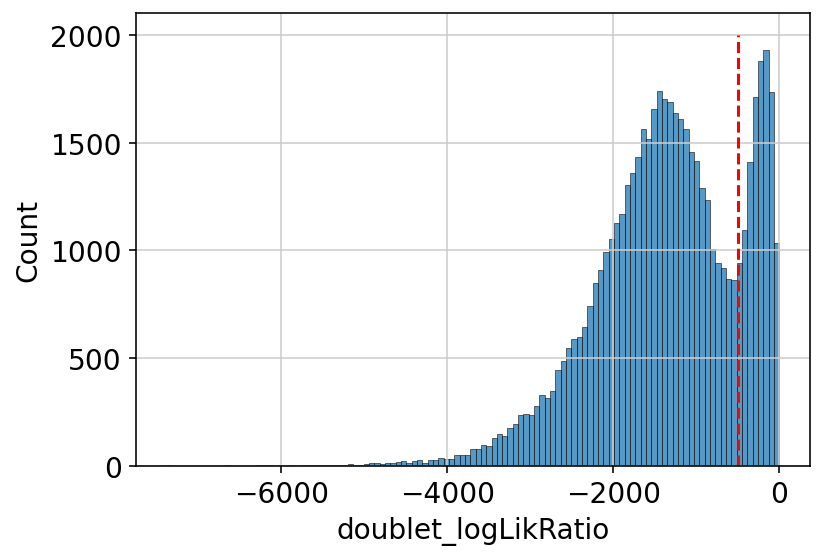

In [24]:
sns.histplot(ipsc.obs['doublet_logLikRatio'])
plt.plot([-500, -500], [0, 2000], 'r--')

In [153]:
ipsc_filt = ipsc[ipsc.obs['doublet_logLikRatio'] <= -500]
ipsc_filt.shape

(42686, 5000)

54241 to 42686 (11,555 cells removed)

<AxesSubplot:xlabel='total_counts', ylabel='Count'>

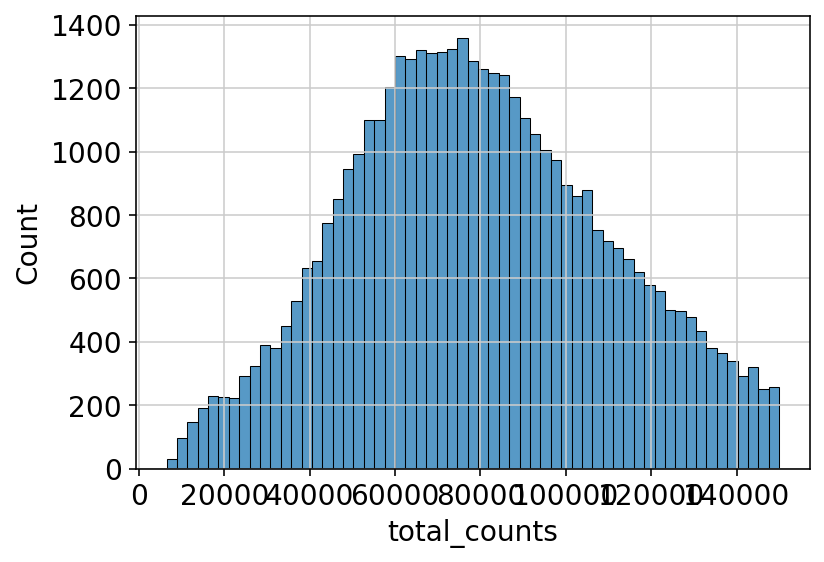

In [32]:
sns.histplot(ipsc_filt.obs['total_counts'])

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Count'>

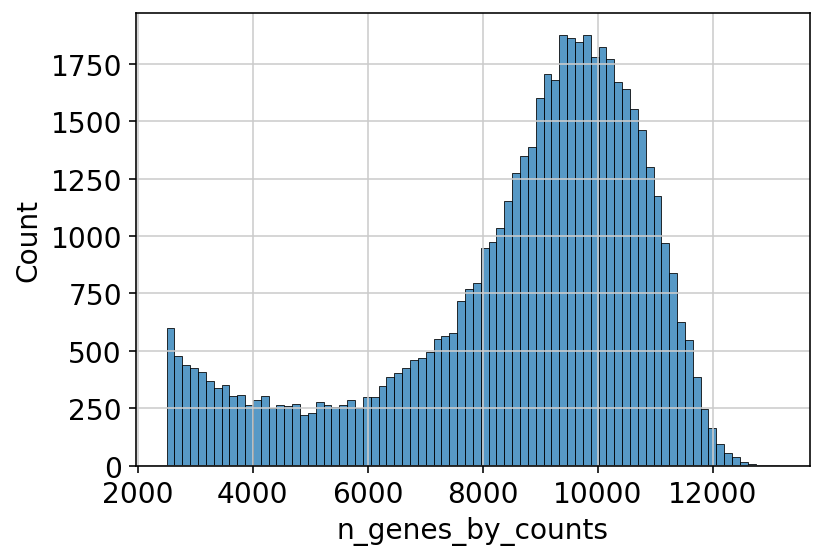

In [33]:
sns.histplot(ipsc.obs['n_genes_by_counts'])

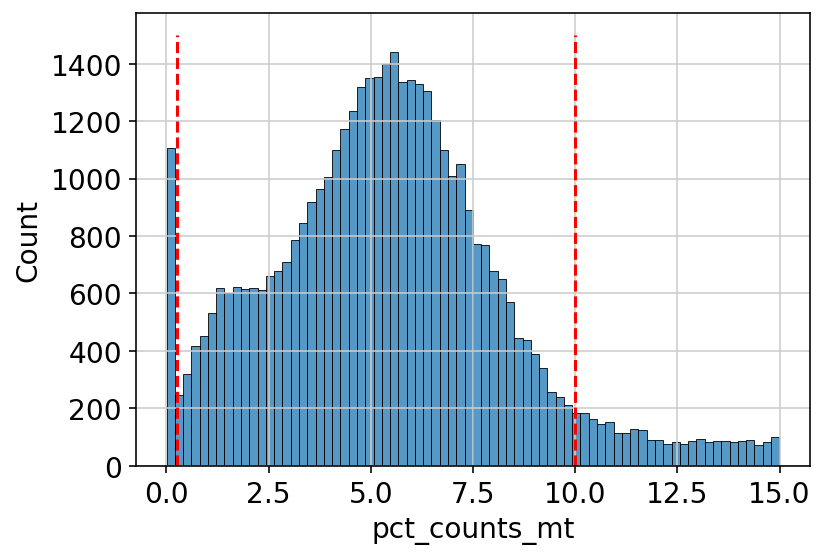

In [46]:
sns.histplot(ipsc_filt.obs['pct_counts_mt'])
plt.plot([0.25, 0.25], [0, 1500], 'r--')
plt.plot([10, 10], [0, 1500], 'r--')

In [154]:
ipsc_filt = ipsc_filt[(ipsc_filt.obs['pct_counts_mt'] >= 0.25) & (ipsc_filt.obs['pct_counts_mt'] < 10)]
ipsc_filt.shape

(38915, 5000)

42686 to 38915 (3,771 cells removed)

<AxesSubplot:xlabel='total_counts_mt', ylabel='Count'>

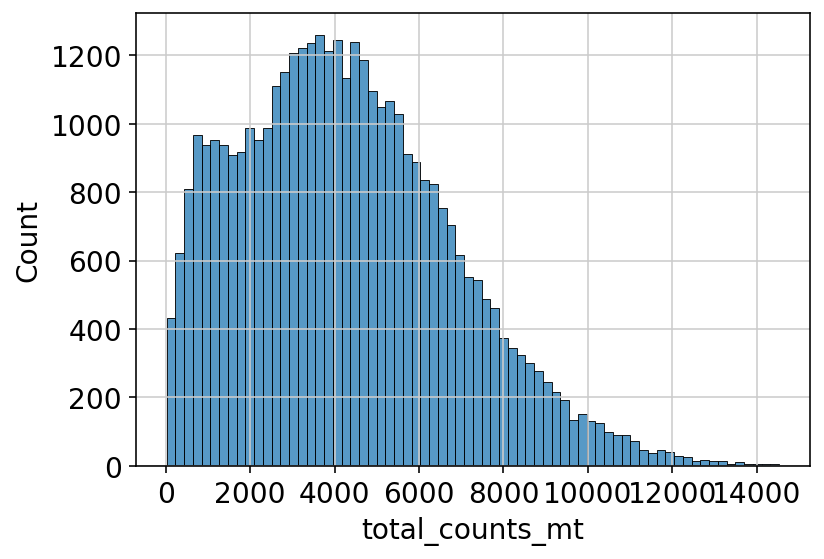

In [48]:
sns.histplot(ipsc_filt.obs['total_counts_mt'])

## Sample Summary

In [59]:
cell_counts = ipsc_filt.obs[['donor_id_x']]
cell_counts = pd.DataFrame(cell_counts.value_counts()).reset_index(inplace=False).rename(columns={0: "n_cells"})
cell_counts

,donor_id_x,n_cells
0,NA18907,6879
1,NA19153,6348
2,NA19144,5117
3,NA19127,3563
4,NA18913,2485
5,NA18486,1902
6,NA19210,1889
7,NA18862,1258
8,NA18855,981
9,NA19093,959


In [60]:
cell_counts['type'] = "IPSC"
cell_counts['individual'] = [s.replace("NA", "") for s in cell_counts['donor_id_x']]
cell_counts['n_umi'] = np.nan
cell_counts['ind_type'] = cell_counts['individual'].astype(str) + "_" + cell_counts['type'].astype(str)
cell_counts = cell_counts[['ind_type', 'n_umi', 'individual', 'type', 'n_cells']]
cell_counts

,ind_type,n_umi,individual,type,n_cells
0,18907_IPSC,NaN,18907,IPSC,6879
1,19153_IPSC,NaN,19153,IPSC,6348
2,19144_IPSC,NaN,19144,IPSC,5117
3,19127_IPSC,NaN,19127,IPSC,3563
4,18913_IPSC,NaN,18913,IPSC,2485
5,18486_IPSC,NaN,18486,IPSC,1902
6,19210_IPSC,NaN,19210,IPSC,1889
7,18862_IPSC,NaN,18862,IPSC,1258
8,18855_IPSC,NaN,18855,IPSC,981
9,19093_IPSC,NaN,19093,IPSC,959


In [61]:
cell_counts['dropped'] = cell_counts['n_cells'] < 5

In [52]:
cell_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/ebqtl_ipscfilt/pseudobulk-scran/sample_summary.tsv",
                  sep="\t", index=False)

In [62]:
ind_counts = cell_counts[cell_counts['n_cells'] >= 5]
ind_counts = pd.DataFrame(ind_counts[['type']].value_counts()).reset_index(inplace=False).rename(columns={0: "n"})
ind_counts = ind_counts[ind_counts['n']>25]
ind_counts

,type,n
0,IPSC,41


In [54]:
ind_counts.to_csv("/project2/gilad/jpopp/ebQTL/data/static/ebqtl_ipscfilt/pseudobulk-scran/samples_per_celltype.tsv",
                  sep="\t", index=False)

## Get raw counts

In [63]:
cell_types_inc = ind_counts['type']

In [64]:
samples_inc = cell_counts[(cell_counts['dropped'] == False) & (cell_counts['type'].isin(cell_types_inc))]['ind_type']
samples_inc

0     18907_IPSC
1     19153_IPSC
2     19144_IPSC
3     19127_IPSC
4     18913_IPSC
5     18486_IPSC
6     19210_IPSC
7     18862_IPSC
8     18855_IPSC
9     19093_IPSC
10    19159_IPSC
11    19102_IPSC
12    18912_IPSC
13    19193_IPSC
14    19207_IPSC
15    18856_IPSC
16    18517_IPSC
17    18507_IPSC
18    19143_IPSC
19    19204_IPSC
20    18519_IPSC
21    18511_IPSC
22    18502_IPSC
23    18489_IPSC
24    19225_IPSC
25    18498_IPSC
26    19140_IPSC
27    19160_IPSC
28    18516_IPSC
29    18505_IPSC
30    18508_IPSC
31    18501_IPSC
32    18499_IPSC
33    19101_IPSC
34    18522_IPSC
35    19099_IPSC
36    19257_IPSC
37    19152_IPSC
38    19128_IPSC
39    19098_IPSC
40    18870_IPSC
Name: ind_type, dtype: object

In [65]:
cell_subset = ipsc_filt.obs[['donor_id_x']]
cell_subset['type'] = "IPSC"
cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id_x'].astype(str)]
cell_subset['sample'] = cell_subset['ind'] + "_" + cell_subset['type']
cell_subset = cell_subset[cell_subset['sample'].isin(samples_inc)]
cell_subset

/tmp/jobs/22954965/ipykernel_22468/2637658615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['type'] = "IPSC"
/tmp/jobs/22954965/ipykernel_22468/2637658615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['ind'] = [s.replace("NA", "") for s in cell_subset['donor_id_x'].astype(str)]
/tmp/jobs/22954965/ipykernel_22468/2637658615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

,donor_id_x,type,ind,sample
cell,,,,
TCGTGGGTCCGCTGTT-91,NA18486,IPSC,18486,18486_IPSC
AAGAACATCAAGGCTT-40,NA19093,IPSC,19093,19093_IPSC
GCAACATCAGAAGCGT-31,NA19153,IPSC,19153,19153_IPSC
TTATTGCCACTACGGC-17,NA19210,IPSC,19210,19210_IPSC
AATGACCAGCGAACTG-73,NA19127,IPSC,19127,19127_IPSC
...,...,...,...,...
CCGGACAGTACGGGAT-25,NA18907,IPSC,18907,18907_IPSC
CAGTTCCCAACTCCCT-23,NA18912,IPSC,18912,18912_IPSC
TGGTTAGAGGTGCATG-81,NA19127,IPSC,19127,19127_IPSC


In [66]:
scran_adata = sc.read_h5ad("/project2/gilad/ktayeb/ebqtl-workflowr/output/proc/EB_high_pass_filtered_normalized.h5ad")

In [67]:
scran_adata = scran_adata[cell_subset.index]
scran_adata

View of AnnData object with n_obs × n_vars = 38908 × 35324
    obs: 'sample_id', 'Collection.Date', 'Lane', 'Sample.ID', 'cDNA.amp.cycles', 'cDNA.total.yield', 'library.prep.batch', 'Sequencing.batch', 'col.group', 'donor_id', 'prob_max', 'prob_doublet', 'n_vars', 'best_singlet', 'best_doublet', 'doublet_logLikRatio', 'Line.True', 'Line.StockLabel', 'contaminated', 'swapped', 'Feeder.passage', 'Feeder.Free.passage', 'sex', 'Formation.replicate', 'collection.replicate', 'formation.date', 'visual.confluence', 'total.cells.per.lane..correct.', 'X..Viable..based.on.average.of.two.counts.', 'days.maintained.in.LD.prior.to.formation', 'who.dissociated.the.lines.for.formation', 'cell.counter.correction', 'comments', 'collection.date', 'collection.group.label', 'EB.appearance.notes', 'dissociated.by.', 'approx..time.in.accumax..in.minutes.', 'leiden_coarse', 'sizeFactor', 'scranGroup', 'scranCluster'
    var: 'gene_ids', 'feature_types'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: '

In [113]:
norm_counts = scipy.sparse.csr_matrix.expm1(scran_adata.X)
size_factors = np.array(scran_adata.obs['sizeFactor'])
raw_counts = np.rint(norm_counts.transpose().multiply(size_factors).toarray())

Saving the raw counts matrix for these high quality cells for further analysis in R, along with metadata

In [162]:
ipsc_filt = ipsc_filt[cell_subset.index].raw.to_adata()

In [163]:
ipsc_filt.layers['counts'] = np.transpose(raw_counts)

In [165]:
ipsc_filt.write_h5ad("/project2/gilad/jpopp/ebQTL/data/single_cell_objects/highpass/cellid_annotated.ipscfilt_only.h5ad")